## Imports

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os

# Title
<center><img src='banner_ml2.png'></center>

# Executive Summary

# Introduction

# Problem Statement

# Data

## Load Data

In [153]:
df_raw = pd.read_csv('C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\\survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


# Methodology

## EDA

### Removing unwanted columns

After carefully reviewing the dataset's columns, an initial set of columns were handpicked by the group to include in our regression models. The group chose the columns that were hypothesized to have significant impact on the salary variable. The final set of features were established after many iterations of testing. 

In [154]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.head(3)

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, mobile",20 to 99 employees,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,PostgreSQL;SQLite,NaN,MacOS,A few times per month or weekly,25-34 years old,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,NaN,NaN,JavaScript;Python,PostgreSQL,NaN,Windows,Daily or almost daily,18-24 years old,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,SQLite,Heroku,MacOS,Multiple times per day,18-24 years old,NaN


In [81]:
df_drop.dropna(subset=['ConvertedCompYearly', 'YearsCode', 'YearsCodePro', 'Age', 'EdLevel', 'Employment', 'OrgSize', 'DevType'], inplace=True)

In [82]:
developing_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 
                        'Sri Lanka', 'Georgia', 'Turkey', 'Pakistan', 'Lebanon', 
                        'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                        'Syrian Arab Republic', 'Viet Nam', 
                        "Lao People's Democratic Republic", 'Nepal', 'Philippines', 
                        'Azerbaijan', 'Armenia', 'Thailand', 'Myanmar', 'Kazakhstan', 
                        'Iraq', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 'Tajikistan', 
                        'Palestine', 'Afghanistan', 'Mongolia', 'Maldives','Turkmenistan']


df_drop = df_drop[df_drop['Country'].isin(developing_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
33,34,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, game or graphics",2 to 9 employees,Assembly;C;C#;C++;HTML/CSS;Java;JavaScript;Mat...,NaN,NaN,Windows,A few times per week,18-24 years old,11832.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
102,103,I am a developer by profession,Employed full-time,Pakistan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,1,"Developer, back-end;Student",20 to 99 employees,Python,NaN,AWS,Linux-based,A few times per month or weekly,18-24 years old,7788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83399,83400,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,6,"Developer, front-end",20 to 99 employees,HTML/CSS;JavaScript;TypeScript,NaN,AWS;Microsoft Azure,MacOS,A few times per week,25-34 years old,27923.0
83407,83408,I am a developer by profession,Employed full-time,Kyrgyzstan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,3,"Developer, front-end","10,000 or more employees",HTML/CSS;JavaScript;TypeScript,NaN,NaN,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,20616.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,5,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0
83422,83423,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Viet Nam,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",26,18,"Developer, full-stack","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;PHP;Ruby,MariaDB;PostgreSQL;SQLite,NaN,Linux-based,NaN,35-44 years old,20000.0


In [83]:
len(developing_countries)

33

In [84]:
data_dev_list = ['Data scientist or machine learning specialist',
                 'Database administrator',
                 'Data or business analyst',
                 'Engineer, data']

ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,11,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,2,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15,13,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


### OHE semicolon features

Some of the categorical features had multiple value entries which were separated by a semi-colon. Because of this, the usual and convenient way of one hot encoding was not possible. To do this, a function was made to split the values in each row with the semi-colon as the separator, create a column for each unique value, and assigned a 1 or a 0 in a column if the value associated with that column is present on that row. The features that needed this type of encoding are `LanguageHaveWorkedWith`, `DevType`, `DatabaseHaveWorkedWith`, and `PlatformHaveWorkedWith`.

In [85]:
df_devs['LanguageHaveWorkedWith'] = df_devs['LanguageHaveWorkedWith'].copy().fillna('other')

In [86]:
li = []
for row in df_devs['LanguageHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

39

In [87]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [88]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 39, 'Lang')
lang_OHE

,Lang_Python,Lang_SQL,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,Lang_C++,Lang_C#,Lang_Bash/Shell,...,Lang_Julia,Lang_Haskell,Lang_Clojure,Lang_COBOL,Lang_Erlang,Lang_Crystal,Lang_LISP,Lang_APL,Lang_other,Lang_F#
index,,,,,,,,,,,,,,,,,,,,,
29,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
148,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83291,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83294,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
li = []
for row in df_devs['DevType'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

25

In [90]:
Dev_OHE = OHE_semicolon_vals('DevType', 25, 'Dev')
Dev_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,Dev_Data scientist or machine learning specialist,"Dev_Engineer, data","Dev_Developer, front-end",Dev_Data or business analyst,"Dev_Developer, desktop or enterprise applications",Dev_System administrator,"Dev_Developer, mobile",...,Dev_Engineering manager,"Dev_Engineer, site reliability",Dev_Academic researcher,Dev_Educator,Dev_Student,"Dev_Developer, game or graphics",Dev_Scientist,"Dev_Senior Executive (C-Suite, VP, etc.)",Dev_Other (please specify):,Dev_Marketing or sales professional
index,,,,,,,,,,,,,,,,,,,,,
29,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
168,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
83291,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83294,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df_devs['DatabaseHaveWorkedWith'] = df_devs['DatabaseHaveWorkedWith'].copy().fillna('other')

In [92]:
li = []
for row in df_devs['DatabaseHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

15

In [93]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 15, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_SQLite,DB_MongoDB,DB_Microsoft SQL Server,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
index,,,,,,,,,,,,,,,
29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
154,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0
83291,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
83294,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [94]:
df_devs['PlatformHaveWorkedWith'] = df_devs['PlatformHaveWorkedWith'].copy().fillna('other')

In [95]:
li = []
for row in df_devs['PlatformHaveWorkedWith'].str.split(';'):
    li = li + row
len(pd.Series(li).unique())

8

In [96]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 8, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_other,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,,
29,0,0,1,0,0,0,0,0
58,0,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0,0
154,0,0,0,0,0,1,0,0
168,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
83046,1,0,0,0,1,0,0,0
83291,0,1,0,0,0,0,0,0
83294,0,1,0,0,0,0,0,0


### Normal OHE

The remaining categorical features could be one hot encoded using the usual way. To do this, the `get_dummies()` function of `pandas` was used. The features that needed this encoding are `Employment`, `Country`, `Age`, and `OpSys`.


In [97]:
df_devs.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'OpSys', 'SOPartFreq', 'Age',
       'ConvertedCompYearly'],
      dtype='object')

In [98]:
df_devs['EdLevel'].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Professional degree (JD, MD, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Associate degree (A.A., A.S., etc.)', 'Primary/elementary school',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else'], dtype=object)

In [99]:
OHE_list = ['Employment', 'Country', 'Age', 'OpSys']
pd.get_dummies(df_devs[OHE_list])

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL)
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
154,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83356,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [100]:
all_OHE = pd.concat([pd.get_dummies(df_devs[OHE_list]), platform_OHE, Dev_OHE, lang_OHE, database_OHE], axis=1)
all_OHE

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83356,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


### Ordinal

For ordinal features, categorical features that have ordinality, mapping functions were made to transform these ordinalities into their numeric representations. Features that needed this type of encoding are `MainBranch`, `EdLevel`, `OrgSize`, and `SOPartFreq`.

In [101]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [102]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)


In [103]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [104]:
SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

Once all the encoding has been finished, converting the `ConvertedCompYearly` to an `int` data type was the last step before merging all the encoded features into one data frame. This data frame will be used in the regression analysis. The data frame's first 10 rows is displayed below.

In [105]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)

In [106]:
df_encoded = pd.merge(df_devs, all_OHE, left_index=True, right_index=True).drop(columns=['DevType',
                                                                            'Employment',
                                                                            'Country',
                                                                            'Age',
                                                                            'OpSys',
                                                                            'LanguageHaveWorkedWith', 
                                                                            'DatabaseHaveWorkedWith', 
                                                                            'PlatformHaveWorkedWith', 'ResponseId'], axis=0)
df_encoded.head(10)

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,6,20,16,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,8,5,3,4,1.0,22644,1,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,6,2,2,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
154,1,5,20,7,1,4.0,2340,0,0,1,...,1,1,1,0,0,0,0,0,0,0
168,1,3,4,2,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,0,0,0,0
213,1,7,15,9,9,2.0,75492,1,0,0,...,0,0,0,0,0,0,0,0,0,0
378,1,5,12,5,2,0.0,217800,1,0,0,...,0,0,0,1,1,0,0,0,0,0
412,1,3,7,3,1,5.0,72000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
554,1,5,3,1,1,3.0,11724,0,0,1,...,0,0,0,0,0,0,0,0,0,0
571,1,5,10,8,3,3.0,29320,1,0,0,...,1,0,0,1,1,1,0,0,0,0


In [107]:
def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    else:
        return int(x)

df_encoded['YearsCode'] = df_encoded['YearsCode'].copy().apply(years_code_mapping)
#YearsCodePro
df_encoded['YearsCodePro'] = df_encoded['YearsCodePro'].copy().apply(years_code_mapping)


### Removing Outliers

**add**

In [108]:
from sklearn.ensemble import IsolationForest
isoforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.12 , max_features=1, random_state=11)
isoforest.fit(df_encoded[['ConvertedCompYearly']])

df_encoded['scores']=isoforest.decision_function(df_encoded[['ConvertedCompYearly']])
df_encoded['anomaly']=isoforest.predict(df_encoded[['ConvertedCompYearly']])

X does not have valid feature names, but IsolationForest was fitted with feature names


In [109]:
outliers_iso = df_encoded[df_encoded['anomaly']==-1].index
print('number of outliers: ', len(outliers_iso), '\n shape of df_final with outliers: ', df_encoded.shape)
df_encoded.drop(outliers_iso, axis=0, inplace=True)

number of outliers:  148 
 shape of df_final with outliers:  (1247, 143)


In [110]:
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,scores,anomaly
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,0,0,0.065146,1
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,1,0,0,0,0,0,0.093599,1
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,0,0,0.063527,1
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,1,0,0,0,0,0,0,0,0.035999,1
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,0,0,0.084331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,1,0,0,0,0,0,0,0.095315,1
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,1,0,0,0,0,0,0.099633,1
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,0,0,0,0.064865,1
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,1,0,0,0,0,0,0,0,0.106633,1


### Adding Counts

Apart from the features available in the dataset, the counts of the languages, databases, platforms, and previous coding jobs were also added as engineered features in attempts to improve the MAEs from previous iterations. The resulting features are `LCount`, `DCount`, `PCount`, `DbCount` which represents the the counts of the languages, databases, platforms, and previous coding jobs that each participant has worked with or worked as, respectively.

In [111]:
def filter_lang(prefix):
    li = []
    for elem in df_encoded.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_encoded['LCount'] = df_encoded[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_encoded['DCount'] = df_encoded[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_encoded['PCount'] = df_encoded[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_encoded['DbCount'] = df_encoded[db_cols].sum(axis=1)


In [112]:
df_encoded.drop(columns=['scores', 'anomaly'], inplace=True)

In [113]:
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,3,4,1,1
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,1,0,0,0,0,0,5,2,1,1
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,1,2,1,1
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,0,7,8,1,5
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,4,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,0,5,7,2,4
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,1,0,0,0,0,0,6,3,1,4
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,0,2,4,1,4
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,0,18,16,6,7


### Adding back Country

During previous iterations, it was observed that when splitting the data into train and test splits, there were train sets that had no data point from a certain country, say, Philippines for example. But a data point from that country is present in the test split. This would mean that the model would perform badly on cases like this since the model was not trained for a datapoint with that country value. This case would be observed for data points that belonged to countries that had only a few samples. To resolve this, the `Country` column from the original dataset was added back into the final data frame. This column would then be used in the `stratify` parameter of sklearn's `train_test_split` function. This allows the splitting to have both train and test splits to have data points that belonged to the more "rare" countries. 

In [114]:
df_encoded = pd.merge(df_encoded, df_devs['Country'], how='left', right_index=True, left_index=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


### Dropping countries that have < 5 rows

Another observation after previous iterations, was that data points that belonged to a rare country needed to be dropped if the total number of data points were less than 5. This is because sklearns `StratefiedKFold` function with 5 splits, required at least 5 data points for a certain country in order to do the stratification on the `Country` column. To be able to do the folds with 5 splits, dropping of these data points was done. A total of 22 rows were dropped.  

In [115]:
drop_list = []
for country in df_encoded['Country'].unique():
    df = df_encoded[df_encoded['Country']==country]
    if len(df) < 5:
        for elem in df.index:
            drop_list.append(elem)
len(drop_list)

22

In [116]:
df_encoded.drop(drop_list, inplace=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


# ML
Once the data is finally prepared and ready, a set of regression models were chosen to be train and tested. Models such as `XGBoost`, `Random Forest`, `Gradient Boosting Method`, `KNN`, and `Multi Layer Perceptron` was used. 

In [118]:
X = df_encoded[df_encoded.columns.difference(['ConvertedCompYearly'])]
y = df_encoded['ConvertedCompYearly']

X_xgb = X
y_xgb = y

## Splitting

Prior to model fitting and testing, a proper splitting of train and test sets is done. The 75-25 train-test splitting is stratified according to the country as mentioned in the previous sections. 

After splitting the models are then train, evaluated, and tested. The optimal hyperparameters are obtained using cross-validation (CV). For this project, the hyperparameter tuning framework used for CV is optuna's framework. 

It is also important to note that scaling of the features were also included in the pipeline as it was deemed necessary to do based from previous iterations. This was necessary especially for the target variable which is the annual compensation of the participants as previous iterations without scaling resulted in a high MAE. A `MinMaxScaler()` was applied on the target variable on a per country basis and not the whole data set. This was suggested by our mentor  Prof. Ibanez. 

The following sections are the training, evaluation, and testing of the mentioned models. The average validation score, optimal parameters, and average test scores are displayed in that order. 

In [46]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

## XGBoost

In [48]:
def tune_XGBoost(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 2,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        # Classifier definition
        model = xgb.XGBRegressor(seed=20, **param)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['xgb', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']

            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem


            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [49]:
xgb_study, xgb_optimize = tune_XGBoost(X_trainval, y_trainval)

[I 2021-12-02 20:41:18,039] A new study created in memory with name: no-name-090b8e81-1342-4840-89b4-94d2f5c48454
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:41:20,579] Trial 1 finished with value: 10591.503781383633 and parameters: {'lambda': 3.967863483557992, 'alpha': 0.2654192000874032, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.5, 'learning_rate': 0.7466308663149559, 'n_estimators': 130, 'max_depth': 13, 'min_child_weight': 198}. Best is trial 1 with value: 10591.503781383633.
[I 2021-12-02 20:41:23,698] Trial 3 finished with value: 8708.998107662119 and parameters: {'lambda': 0.01887248952661114, 'alpha': 0.5336643240525143, 'colsample_bytree': 0.8, 'subsample': 0.9000000000000001, 'learning_rate': 0.03385469711514547, 'n_estimators': 340, 'max_depth': 12, 'min_child_weight': 259}. Best is trial 3 with value: 8708.998107662119.
[I 2021-12-02 20:41:23

In [50]:
xgb_study.best_value

8023.153009851274

In [51]:
xgb_study.best_params

{'lambda': 0.001228727936529487,
 'alpha': 0.01002738325350634,
 'colsample_bytree': 1.0,
 'subsample': 0.8,
 'learning_rate': 0.01986165969236614,
 'n_estimators': 470,
 'max_depth': 15,
 'min_child_weight': 79}

In [52]:
def testing_optimal_model(model, n_trials):

    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25, stratify=X['Country'])

        ### Fitting scalers per country
        def get_country_index(X, country):
            return X[X[f'Country_{country}']==1].index

        country_list = X['Country'].unique().tolist()
        country_index_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
            country_index_dict[c] = [get_country_index(X_train, c), scaler]

        #### scaling train sets
        # y
        ytrain_scaled_dict = {}
        for key, val in country_index_dict.items():
            y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
            ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

        y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

        # X 
        X_train_final = X_train.drop(columns=['Country'], axis=0)

        y_train_final.name = 'y'
        y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


        #### scaling val sets
        # y

        country_index_val_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
            country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


        yval_scaled_dict = {}
        for key, val in country_index_val_dict.items():
            y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
            yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

        y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

        # X
        X_val_final = X_val.drop(columns=['Country'], axis=0)


        y_val_final.name = 'y'
        y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



        scaler = MinMaxScaler()
        X_train_feed = scaler.fit_transform(X_train_final)
        X_val_feed = scaler.transform(X_val_final)

        model.fit(X_train_feed, y_train_final)

        y_pred = model.predict(X_val_feed)

    #     ### Inverse scaling before calculating MAE
        y_pred_dict = {}
        for key, val in country_index_val_dict.items():
            val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
            y_country = y_pred[val_indices]
            # inverse minmax scaling....
            y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
            y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


        y_val_dict = {}
        for key, val in y_pred_dict.items():
            y_val_country = y_val_final.reset_index(drop=True)[val[0]]
            y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
            y_val_dict[key] = y_val_country_inversed_scaled.ravel()

        y_val_sorted = [list(elem) for elem in y_val_dict.values()]
        y_val_mae = []
        for elem in y_val_sorted:
            y_val_mae = y_val_mae + elem

        y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
        y_pred_mae = []
        for elem in y_pred_sorted:
            y_pred_mae = y_pred_mae + elem


        mae = mean_absolute_error(y_val_mae, y_pred_mae)
        r2 = r2_score(y_val_mae, y_pred_mae)
        mape = mean_absolute_percentage_error(y_val_mae, y_pred_mae)
        rmse = np.sqrt(mean_squared_error(y_val_mae, y_pred_mae))
        
        mae_list.append(mae)
        mape_list.append(mape)
        rmse_list.append(rmse)
        r2_list.append(r2)
    return np.mean(mae_list), np.mean(mape_list), np.mean(rmse_list), np.mean(r2_list), mae_list

In [53]:
# {'lambda': 2.6023460786610775,
#  'alpha': 0.031034911484978875,
#  'colsample_bytree': 0.9000000000000001,
#  'subsample': 0.5,
#  'learning_rate': 0.035172129329832345,
#  'n_estimators': 350,
#  'max_depth': 2,
#  'min_child_weight': 11}

xgbr = xgb.XGBRegressor(seed=20, **xgb_study.best_params)
# xgbr = xgb.XGBRegressor(seed=20, **{'lambda': 2.6023460786610775,
#                                   'alpha': 0.031034911484978875,
#                                   'colsample_bytree': 0.9000000000000001,
#                                   'subsample': 0.5,
#                                   'learning_rate': 0.035172129329832345,
#                                   'n_estimators': 350,
#                                   'max_depth': 2,
#                                   'min_child_weight': 11})
xgb_mae, xgb_mape, xgb_rmse, xgb_r2, xgb_mae_list = testing_optimal_model(xgbr, 20)
xgb_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8182.540268780744

## Random Forest

For models other than `XGBoost` rows that have null values on the `SOPartFreq` column will be dropped since sklearn's implementations of these models can not handle missing values unlike that of `XGBoost`. This results in a reduced dataset with no null values. A second similar splitting is performed on the new dataset. 

In [54]:
df_encoded.dropna(inplace=True)
drop_list = []
for country in df_encoded['Country'].unique():
    df = df_encoded[df_encoded['Country']==country]
    if len(df) < 5:
        for elem in df.index:
            drop_list.append(elem)
display(len(drop_list))
df_encoded.drop(drop_list, inplace=True)
X = df_encoded[df_encoded.columns.difference(['ConvertedCompYearly'])]
y = df_encoded['ConvertedCompYearly']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

8

In [55]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import KFold
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features, random_state=11)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']

            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem


            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [56]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-12-02 20:47:48,927] A new study created in memory with name: no-name-e994670e-cd35-4715-8d56-020b0a0419fa
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:47:51,068] Trial 2 finished with value: 8634.019733632176 and parameters: {'n_estimators': 20, 'max_depth': 63, 'max_features': 79}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:53,193] Trial 4 finished with value: 8760.617126645397 and parameters: {'n_estimators': 50, 'max_depth': 65, 'max_features': 48}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:55,485] Trial 5 finished with value: 8709.372152532835 and parameters: {'n_estimators': 40, 'max_depth': 71, 'max_features': 74}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:58,993] Trial 0 finished with value: 8839.918850585316 and parameters: {'n_estimators': 500, 'max_depth': 41, 'max_features': 6}

In [57]:
rf_study.best_value

8572.998632330506

In [58]:
rf_study.best_params

{'n_estimators': 120, 'max_depth': 97, 'max_features': 51}

In [59]:
rf = RandomForestRegressor(**rf_study.best_params, random_state=11)
rf_mae, rf_mape, rf_rmse, rf_r2, rf_mae_list = testing_optimal_model(rf, 20)
rf_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8624.500599799481

## Gradient Boosting Method

In [60]:
def tune_GBM_2(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate, random_state=11)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['gbm', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [61]:
gbm_study_2, gbm_optimize_2 = tune_GBM_2(X_trainval ,y_trainval)

[I 2021-12-02 20:54:26,374] A new study created in memory with name: no-name-1318b7cb-399d-483a-8ea7-3f10d9aaecf3
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:54:31,731] Trial 2 finished with value: 9070.154049649456 and parameters: {'n_estimators': 410, 'max_depth': 69, 'max_features': 65, 'learning_rate': 0.09546668842790389}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:33,533] Trial 3 finished with value: 9195.58238926969 and parameters: {'n_estimators': 160, 'max_depth': 17, 'max_features': 106, 'learning_rate': 0.04473718004336157}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:34,972] Trial 0 finished with value: 9691.698360851626 and parameters: {'n_estimators': 620, 'max_depth': 67, 'max_features': 124, 'learning_rate': 0.09346250087212826}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:36,567] Tr

In [62]:
gbm_study_2.best_params

{'n_estimators': 510,
 'max_depth': 2,
 'max_features': 15,
 'learning_rate': 0.05736266924848544}

In [63]:
gbm_study_2.best_value

8192.438029231931

In [64]:
gbm_2 = GradientBoostingRegressor(**gbm_study_2.best_params, random_state=11)
gbm_mae, gbm_mape, gbm_rmse, gbm_r2, gbm_mae_list = testing_optimal_model(gbm_2, 20)
gbm_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8272.64538547835

## KNN

In [65]:
def tune_KNN(X, y):
    
    def optimize(trial):
        # Definition of space search
        n_neighbors = trial.suggest_int('n_neighbors', 2, 300, step=10)
        
        
        # Classifier definition
        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [66]:
knn_study, knn_optimize = tune_KNN(X_trainval ,y_trainval)

[I 2021-12-02 20:59:30,203] A new study created in memory with name: no-name-e387fee4-44c1-46af-a455-ac7fb407e511
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-02 20:59:32,513] Trial 2 finished with value: 9906.91894980093 and parameters: {'n_neighbors': 202}. Best is trial 2 with value: 9906.91894980093.
The distribution is specified by [2, 300] and step=10, but th

In [67]:
knn_study.best_params

{'n_neighbors': 12}

In [68]:
knn_study.best_value

9150.40264734625

In [69]:
knn = KNeighborsRegressor(**knn_study.best_params)
knn_mae, knn_mape, knn_rmse, knn_r2, knn_mae_list = testing_optimal_model(knn, 20)
knn_mae

  0%|          | 0/20 [00:00<?, ?it/s]

9398.783208644807

## MLP

In [70]:
def tune_MLP(X, y):

    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_layers = trial.suggest_int('n_layers', 1, 4)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))
        
        
        activations = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
        alpha = trial.suggest_float('alpha', 1e-4, 0.6)
        solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        
        # Classifier definition
        model = MLPRegressor(hidden_layer_sizes=tuple(layers),
                             activation=activations,
                             alpha=alpha,
                             learning_rate=learning_rate,
                             solver=solver, 
                             random_state=11, 
                             max_iter=1_000_000)

        scaler = MinMaxScaler()
        
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=100, n_jobs=4)
    return study, optimize

### CV

In [71]:
MLP_study, MLP_optimize = tune_MLP(X_trainval , y_trainval)

[I 2021-12-02 21:01:50,530] A new study created in memory with name: no-name-55f35d8c-e828-4667-97c5-0ca2887b76b0
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 21:01:54,749] Trial 0 finished with value: 10949.930827212718 and parameters: {'n_layers': 3, 'n_units_0': 100, 'n_units_1': 35, 'n_units_2': 78, 'activation': 'relu', 'alpha': 0.4296008623768964, 'solver': 'sgd', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 10949.930827212718.
[I 2021-12-02 21:01:55,407] Trial 1 finished with value: 15479.406449319304 and parameters: {'n_layers': 2, 'n_units_0': 45, 'n_units_1': 62, 'activation': 'tanh', 'alpha': 0.25608498741828656, 'solver': 'sgd', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 10949.930827212718.
[I 2021-12-02 21:02:03,722] Trial 2 finished with value: 11505.798881012113 and parameters: {'n_layers': 1, 'n_units_0': 16, 'activation': '

In [72]:
MLP_study.best_params

{'n_layers': 3,
 'n_units_0': 2,
 'n_units_1': 58,
 'n_units_2': 50,
 'activation': 'tanh',
 'alpha': 0.41752566746433967,
 'solver': 'adam',
 'learning_rate': 'adaptive'}

In [73]:
MLP_study.best_value

8378.338362886758

In [74]:
tup=[]
study = MLP_study.best_params
for layer in range(study['n_layers']):
    tup.append(study[f'n_units_{layer}'])
    del study[f'n_units_{layer}']
del study['n_layers']
tup = tuple(tup)
tup

(2, 58, 50)

In [75]:
mlp = MLPRegressor(hidden_layer_sizes=tup, **study, random_state=11, max_iter=1_000_000)
mlp_mae, mlp_mape, mlp_rmse, mlp_r2, mlp_mae_list = testing_optimal_model(mlp, 20)
mlp_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8393.132484272193

## ML Summary
The table below shows the summary of the model results. Among the 5 models tested, `XGBoost` provided the best MAE of 8182. This model will be used to interpret the results in the following section.

In [76]:
df_ml_summary = pd.DataFrame([[xgb_mae, xgb_study.best_value][::-1],
              [rf_mae, rf_study.best_value][::-1],
              [gbm_mae, gbm_study_2.best_value][::-1],
              [knn_mae, knn_study.best_value][::-1],
              [mlp_mae, MLP_study.best_value][::-1]], 
             index=['XGBoost', 'Random Forest', 'GBM', 'KNN', 'MLP'],
             columns=['Avg Test MAE', 'Avg Val MAE'][::-1]
             )
df_ml_summary

,Avg Val MAE,Avg Test MAE
XGBoost,8023.153010,8182.540269
Random Forest,8572.998632,8624.500600
GBM,8192.438029,8272.645385
KNN,9150.402647,9398.783209
MLP,8378.338363,8393.132484


# XGBoost Interpretation using SHAP

In [119]:
X = X_xgb
y = y_xgb

In [120]:
display(np.argmin(xgb_mae_list))
xgb_mae_list[np.argmin(xgb_mae_list)]

7

7788.454277208117

In [122]:
(X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                      random_state=np.argmin(xgb_mae_list), 
                                                      test_size=0.25, stratify=X['Country'])

### Fitting scalers per country
def get_country_index(X, country):
    return X[X[f'Country_{country}']==1].index

country_list = X['Country'].unique().tolist()
country_index_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
    country_index_dict[c] = [get_country_index(X_train, c), scaler]

#### scaling train sets
# y
ytrain_scaled_dict = {}
for key, val in country_index_dict.items():
    y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
    ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

# X 
X_train_final = X_train.drop(columns=['Country'], axis=0)

y_train_final.name = 'y'
y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


#### scaling val sets
# y

country_index_val_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
    country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


yval_scaled_dict = {}
for key, val in country_index_val_dict.items():
    y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
    yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

# X
X_val_final = X_val.drop(columns=['Country'], axis=0)


y_val_final.name = 'y'
y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']


scaler = MinMaxScaler()
X_train_feed = scaler.fit_transform(X_train_final)
X_val_feed = scaler.transform(X_val_final)

xgbr.fit(X_train_feed, y_train_final)

y_pred = xgbr.predict(X_val_feed)

#     ### Inverse scaling before calculating MAE
y_pred_dict = {}
for key, val in country_index_val_dict.items():
    val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
    y_country = y_pred[val_indices]
    # inverse minmax scaling....
    y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
    y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


y_val_dict = {}
for key, val in y_pred_dict.items():
    y_val_country = y_val_final.reset_index(drop=True)[val[0]]
    y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
    y_val_dict[key] = y_val_country_inversed_scaled.ravel()

y_val_sorted = [list(elem) for elem in y_val_dict.values()]
y_val_mae = []
for elem in y_val_sorted:
    y_val_mae = y_val_mae + elem

y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
y_pred_mae = []
for elem in y_pred_sorted:
    y_pred_mae = y_pred_mae + elem


mae = mean_absolute_error(y_val_mae, y_pred_mae)
mae

7788.454277208117

In [123]:
X_train_2 = pd.DataFrame(X_train_feed, columns=X_train.drop(columns=['Country'], axis=0).columns)

In [134]:
explainer_xgb = shap.Explainer(xgbr)
shap_values = explainer_xgb.shap_values(X_train_2)
shap_values_2 = explainer_xgb(X_train_2)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# plt.figure(figsize=(20,30))
# feat_importances = pd.Series(xgbr.feature_importances_, index=X_val_final.columns)
# feat_importances.sort_values(ascending=True).plot(kind='barh');

In [135]:
shap_values

array([[ 1.6380508e-03, -2.3386192e-03, -7.4068455e-05, ...,
         8.3421227e-03, -4.8718536e-03,  1.7362859e-02],
       [ 2.5064670e-03, -1.0323524e-03, -1.5945124e-04, ...,
         2.0229593e-02,  6.8587698e-02, -3.8282846e-03],
       [-2.2739458e-03,  1.8901203e-03, -1.8999405e-04, ...,
         1.1929815e-02,  8.6156977e-03, -6.6204108e-02],
       ...,
       [ 1.7835500e-03,  1.8343785e-03,  1.1691847e-03, ...,
         8.2151368e-03, -3.2102916e-02,  8.5602738e-02],
       [-3.2556802e-03,  3.1457613e-03, -2.4685287e-04, ...,
        -2.0909277e-03, -3.0651430e-02, -9.2027411e-02],
       [-3.8781222e-03,  1.2515495e-03, -1.8845877e-04, ...,
         1.1081743e-02, -3.1487249e-02, -7.7743456e-02]], dtype=float32)

In [136]:
X_val_final.describe()

,Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Plat_Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,SOPartFreq,YearsCode,YearsCodePro
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.0,270.000000,270.0,270.000000,270.0,...,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,242.000000,270.000000,270.000000
mean,0.292593,0.529630,0.133333,0.033333,0.007407,0.0,0.003704,0.0,0.007407,0.0,...,0.214815,0.348148,0.177778,0.029630,0.211111,0.022222,0.237037,1.483471,10.781481,6.383333
std,0.455798,0.500048,0.340566,0.179839,0.085906,0.0,0.060858,0.0,0.085906,0.0,...,0.411456,0.477268,0.383036,0.169878,0.408855,0.147679,0.426055,1.226326,6.411568,5.841804
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.500000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,2.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,4.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,9.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,38.000000,36.000000


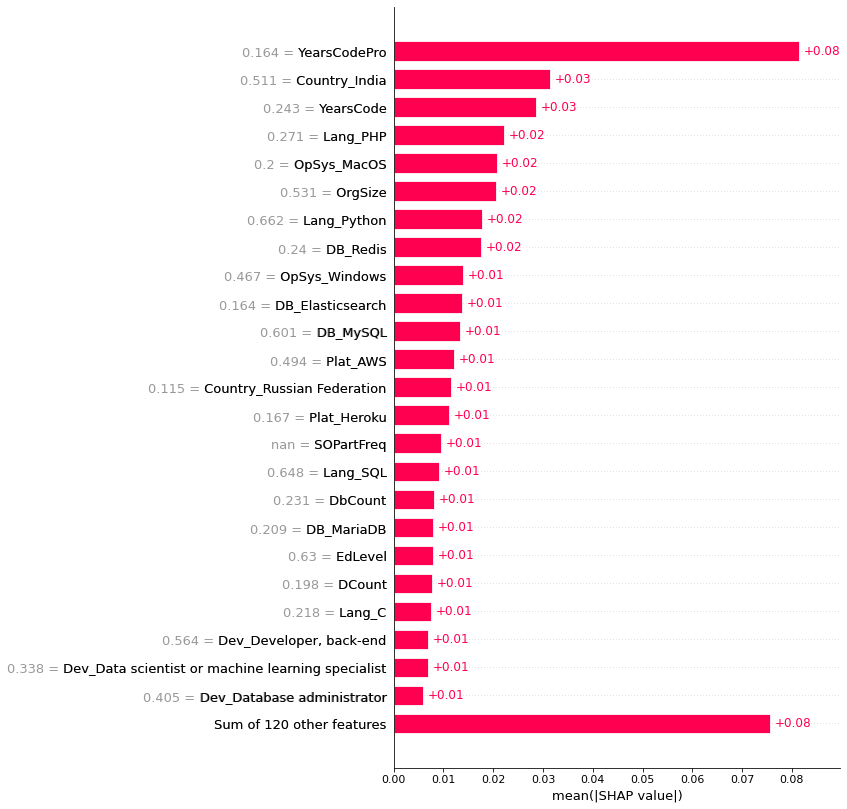

In [137]:
shap.plots.bar(shap_values_2, max_display=25, show_data=True)

In [138]:
X_val_final.columns

Index(['Age_18-24 years old', 'Age_25-34 years old', 'Age_35-44 years old',
       'Age_45-54 years old', 'Age_55-64 years old', 'Age_Prefer not to say',
       'Age_Under 18 years old', 'Country_Afghanistan', 'Country_Armenia',
       'Country_Azerbaijan',
       ...
       'Plat_DigitalOcean', 'Plat_Google Cloud Platform', 'Plat_Heroku',
       'Plat_IBM Cloud or Watson', 'Plat_Microsoft Azure',
       'Plat_Oracle Cloud Infrastructure', 'Plat_other', 'SOPartFreq',
       'YearsCode', 'YearsCodePro'],
      dtype='object', length=144)

In [139]:
X_val_col = X_val_final.rename(columns={
    'YearsCodePro': 'Years Coding Pro', 
    'YearsCode': 'Years Coding',
    'Country_India': 'In India',
    'OrgSize': 'Company Size',
    'SOPartFreq': 'StackOverflow Partcipation',
    'DbCount': "Database used",
    'Lang_PHP': 'PHP',
    'Lang_Python': 'Python',
    'DB_Elasticsearch': 'Elasticsearch',
    'OpSys_MacOS': 'MacOS user',
    'DCount': 'No. of job titles',
    'Age_18-24 years old': 'Age 18-24',
    'Plat_AWS': 'AWS', 
    'Country_Russian Federation': 'In Russia', 
    'DB_MySQL': 'MySQL',
    'EdLevel': 'Education level',
    'Employment_Independent contractor, freelancer, or self-employed': 'Self-employed',
    'OpSys_Windows': 'Windows user',
    'Plat_Google Cloud Platform': 'Google Cloud Platform',
    'Country_China': 'In China',
    'Country_Indonesia': 'In Indonesia',
    'Dev_DevOps specialist': 'DevOps specialist',
    'DB_MariaDB': 'MariaDB'})

X_val_col

,Age 18-24,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,StackOverflow Partcipation,Years Coding,Years Coding Pro
47686,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,3.0,6.0,3.0
8530,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1.0,17.0,9.0
19938,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1.0,8.0,1.0
65289,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,10.0,6.0
58,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75520,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2.0,5.0,2.0
31856,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2.0,8.0,6.0
22371,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1.0,4.0,1.0
24942,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,5.0,18.0,16.0


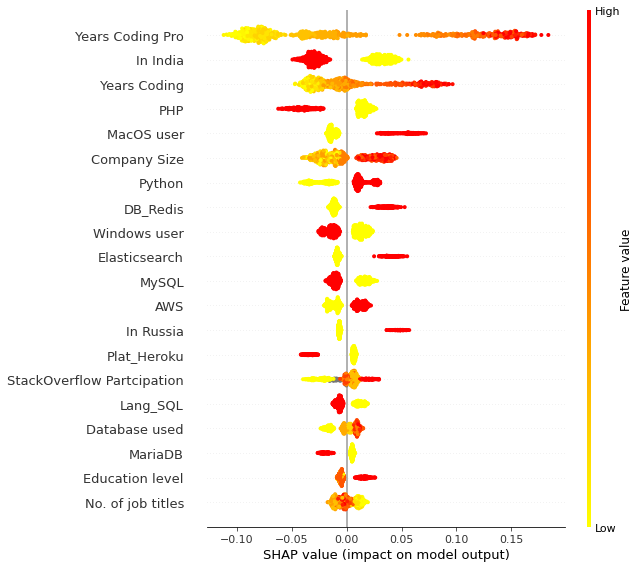

In [142]:
shap.summary_plot(shap_values = shap_values, features = X_train_2, 
                  feature_names=X_val_col.columns, cmap=plt.get_cmap('autumn_r'),
                  max_display=20)

In [141]:
df_encoded[df_encoded['Country']=='India']

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
554,1,5,3.0,1.0,1,3.0,11724,0,0,1,...,0,0,0,0,0,9,9,2,3,India
571,1,5,10.0,8.0,3,3.0,29320,1,0,0,...,1,0,0,0,0,10,7,1,7,India
586,1,5,3.0,0.5,8,2.0,6981,1,0,0,...,0,1,0,0,0,3,1,1,1,India
745,1,5,2.0,1.0,4,1.0,5868,0,0,1,...,0,0,0,0,0,9,2,2,2,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82525,1,5,5.0,2.0,6,1.0,60312,1,0,0,...,0,0,0,0,0,5,5,1,2,India
82534,0,5,15.0,12.0,9,NaN,23460,1,0,0,...,0,0,0,0,0,3,2,1,1,India
82749,1,5,7.0,4.0,2,1.0,9773,1,0,0,...,0,0,0,0,0,4,2,1,2,India
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India


In [ ]:
# model_xgbr = xgbr.fit(X_trainval.drop(columns='Country'), y_trainval)
# y_pred = xgbr.predict(X_holdout.drop(columns='Country'))

# fig, ax = plt.subplots(figsize=(15,10))

# plt.scatter(y_holdout, y_pred)
# ax.axline([0, 0], [y_holdout.max(), y_holdout.max()], color='red')
# # plt.scatter(range(len(y_pred)), y_pred, label='preds')
# # plt.legend()
# plt.show()

In [143]:
xgb_results = pd.DataFrame({'actual': y_val_mae,
                            'pred': y_pred_mae})

print(xgb_results['actual'].quantile(0.25))
print(xgb_results['actual'].quantile(0.50))
print(xgb_results['actual'].quantile(0.75), '\n')

q1 = xgb_results[xgb_results['actual'] <= xgb_results['actual'].quantile(0.25)]
q2 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.25)) & 
                 (xgb_results['actual'] <= xgb_results['actual'].quantile(0.55))]
q3 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.55)) &
                 (xgb_results['actual'] <= xgb_results['actual'].quantile(0.75))]
q4 = xgb_results[xgb_results['actual'] > xgb_results['actual'].quantile(0.75)]

q1['quantile'] = 1
q2['quantile'] = 2
q3['quantile'] = 3
q4['quantile'] = 4

q1['MAE'] = abs(q1['actual'] - q1['pred'])
q2['MAE'] = abs(q2['actual'] - q2['pred'])
q3['MAE'] = abs(q3['actual'] - q3['pred'])
q4['MAE'] = abs(q4['actual'] - q4['pred'])

print(q1.shape)
print(q2.shape)
print(q3.shape)
print(q4.shape, '\n')

print(np.mean(q1['actual']))
print(np.mean(q2['actual']))
print(np.mean(q3['actual']))
print(np.mean(q4['actual']), '\n')

print(mean_absolute_error(q1['actual'], q1['pred']))
print(mean_absolute_error(q2['actual'], q2['pred']))
print(mean_absolute_error(q3['actual'], q3['pred']))
print(mean_absolute_error(q4['actual'], q4['pred']))

8547.0
15358.0
25698.000000000004 

(68, 4)
(80, 4)
(54, 4)
(68, 4) 

5687.808823529412
12551.8125
22385.222222222223
38842.64705882353 

6671.392186781939
6808.432032012939
6007.72575321904
11472.591660443475



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [144]:
df_quantiles = pd.concat([q1,q2,q3,q4])

no_4 = df_quantiles[df_quantiles['quantile'] != 4]
print(np.mean(no_4['actual']))
mean_absolute_error(no_4['actual'], no_4['pred'])

12869.89108910891


6548.249613544728

In [145]:
mandy = pd.DataFrame(columns=X_val_final.columns, index=[0])
mandy['Age_25-34 years old'] = 1
mandy['Country_Philippines'] = 1
mandy['Country_India'] = 0
mandy['YearsCode'] = 0
mandy['YearsCodePro'] = 0
mandy['EdLevel'] = 2
mandy['OrgSize'] = 3
mandy['DB_MongoDB'] = 0
mandy['DB_PostgreSQL'] = 1
mandy['DB_SQLite'] = 1
mandy['Dev_Data or business analyst'] = 0
mandy['Dev_Data scientist or machine learning specialist'] = 1
mandy['Dev_Database administrator'] = 0
mandy['Dev_Developer, back-end'] = 0
mandy['Dev_Developer, front-end'] = 0
mandy['Dev_Developer, full-stack'] = 0
mandy['Dev_Developer, mobile'] = 1
mandy['Dev_Engineer, data'] = 0
mandy['Employment_Employed full-time'] = 1
mandy['Employment_Independent contractor, freelancer, or self-employed'] = 0
mandy['Lang_JavaScript'] = 0
mandy['Lang_PHP'] = 0
mandy['Lang_Python'] = 1
mandy['Lang_R'] = 0
mandy['Lang_SQL'] = 0
mandy['Plat_Heroku'] = 0
mandy['Plat_AWS'] = 1
mandy['Plat_Google Cloud Platform'] = 0
mandy['LCount'] = 2
mandy['PCount'] = 0
mandy['DbCount'] = 0
mandy['DCount'] = 0

mandy = mandy.fillna(0)
mandy

,Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Plat_Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,SOPartFreq,YearsCode,YearsCodePro
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
max(y_val_mae)

62280.0

In [147]:
print(y_pred_dict.get('Philippines')[2].inverse_transform(np.array(xgbr.predict(mandy)).reshape(-1,1)) * 50)

[[1068536.9]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


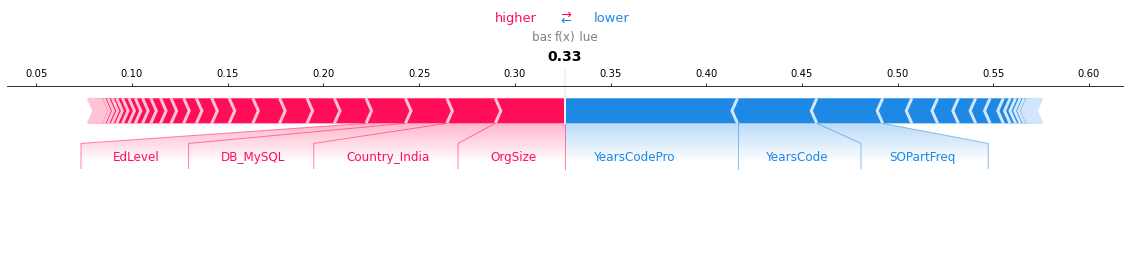

In [148]:
explainer_xgb = shap.TreeExplainer(xgbr)
shap_values_m = explainer_xgb.shap_values(mandy)
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_m, mandy.columns, matplotlib=True)

In [ ]:
df_converted = df_encoded[df_encoded['Country_Philippines']==1]['ConvertedCompYearly'] * 50 /12
df_converted.describe()

In [ ]:
shap.summary_plot(shap_values = shap_values_m, features = mandy, 
                  feature_names=mandy.columns,
                  max_display=15)

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax = plt.scatter(y_val_mae, y_pred_mae, c='#f48304')
plt.axline([0, 0], [max(y_val_mae), max(y_val_mae)], color='r', linestyle='--')

plt.show()

In [ ]:
sns.boxplot(y=df_quantiles['quantile'], x=df_quantiles['MAE'], orient='h', showfliers=False)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_percentage_error(y_holdout, y_pred))
print(np.sqrt(mean_squared_error(y_holdout, y_pred)))
print(mean_absolute_error(y_holdout, y_pred))
print(r2_score(y_holdout, y_pred))

# Key Takeaways